<a href="https://colab.research.google.com/github/bghata/Brand_Selection/blob/master/brand_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext rpy2.ipython

import warnings
warnings.filterwarnings('ignore')

In [0]:
%%R
install.packages("pacman")
library(pacman)

## Loading libraries

In [0]:
%%R
pacman::p_load(readr, caret, randomForest,
               C50, plyr, ggplot2, e1071)

## Loading data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
%%R
CompleteResponses <- read_csv('/content/gdrive/My Drive/Colab Notebooks/Brand_Selection/CompleteResponses.csv')

**Setting the correct data type**

In [0]:
%%R
CompleteResponses$salary <- as.numeric(CompleteResponses$salary)
CompleteResponses$age <- as.integer(CompleteResponses$age)
CompleteResponses$elevel <- as.factor(CompleteResponses$elevel)
CompleteResponses$car <- as.factor(CompleteResponses$car)
CompleteResponses$zipcode <- as.factor(CompleteResponses$zipcode)
CompleteResponses$credit <- as.numeric(CompleteResponses$credit)
CompleteResponses$brand <- as.factor(CompleteResponses$brand)

**Set Seed**

In [0]:
%%R
set.seed(123)

## Create data partition + cross validation of 10 folds

In [0]:
%%R
inTraining <- createDataPartition(CompleteResponses$brand, p = .75, list = FALSE)
trainData <- CompleteResponses[inTraining,]
testData <- CompleteResponses[-inTraining,]
fitControl <- trainControl(method = "repeatedcv", number = 10, repeats = 1)

## Random Forest model

In [0]:
%%R
rfFit1 <- train(brand~.,  
                data = trainData, 
                method = "rf",  
                trControl=fitControl, 
                tuneLength = 2)

In [0]:
%%R
rfFit1

Random Forest 

7424 samples
   6 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 6682, 6681, 6681, 6681, 6681, 6683, ... 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
   2    0.6217673  0.0000000
  34    0.9167500  0.8232374

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 34.


## C5.0 model

In [0]:
%%R
c5fit <- train(brand~., 
               data = trainData, 
               method = "C5.0", 
               trControl=fitControl, 
               tuneLength = 2)

In [0]:
%%R
c5fit

C5.0 

7424 samples
   6 predictor
   2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 6682, 6681, 6682, 6682, 6681, 6682, ... 
Resampling results across tuning parameters:

  model  winnow  trials  Accuracy   Kappa    
  rules  FALSE    1      0.8201844  0.6394397
  rules  FALSE   10      0.9146006  0.8182326
  rules   TRUE    1      0.8305618  0.6591543
  rules   TRUE   10      0.9141968  0.8171296
  tree   FALSE    1      0.8204540  0.6399553
  tree   FALSE   10      0.9178344  0.8255448
  tree    TRUE    1      0.8301575  0.6529988
  tree    TRUE   10      0.9164870  0.8229807

Accuracy was used to select the optimal model using the largest value.
The final values used for the model were trials = 10, model = tree and winnow
 = FALSE.


## Prediction on C5.0 model since accuracy & Kappa were better that RF model

In [0]:
%%R
P1 <- predict(c5fit, trainData)
confusionMatrix(P1, trainData$brand)

P2 <- predict(c5fit, testData)
confusionMatrix(P2, testData$brand)
testData$prediction <- P2
postResample(testData$prediction, testData$brand)

 Accuracy     Kappa 
0.9260307 0.8446670 


**Variables Importance Ranking**

In [0]:
%%R
varImp(c5fit, scale = FALSE)

C5.0 variable importance

  only 20 most important variables shown (out of 34)

         Overall
salary    100.00
age        85.51
car20      54.38
car5       31.72
car2       31.13
credit     29.78
zipcode7   27.57
car10      25.09
elevel3    20.69
car19      13.55
car8       10.30
car17       9.62
zipcode8    8.88
car13       8.73
car3        8.63
zipcode1    7.92
zipcode6    7.34
elevel4     7.30
car4        7.02
car7        4.22


**Plotting C5.0 model**

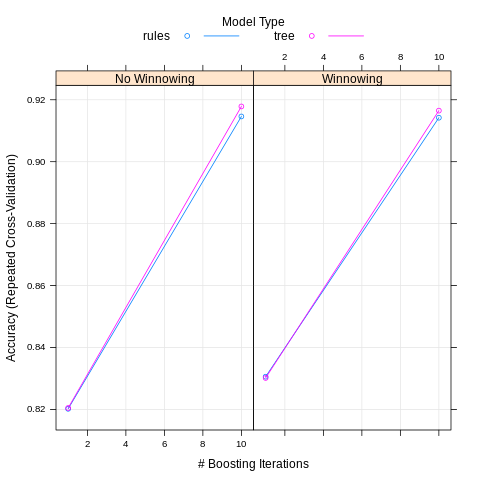

In [0]:
%%R
plot(c5fit)

## Correlation between salary & age

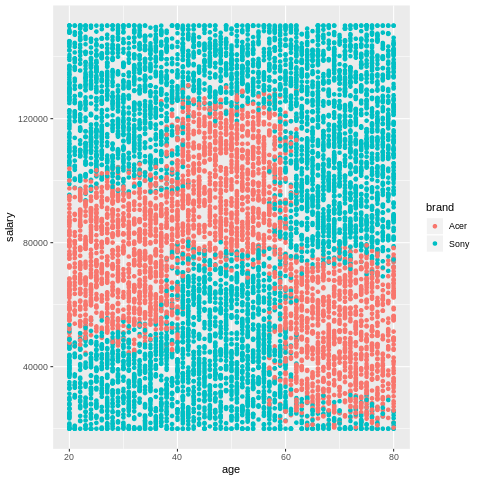

In [0]:
%%R
CompleteResponses$brand = mapvalues(CompleteResponses$brand, 
                          from = c("0", "1"), to = c("Acer", "Sony"))
geom_point(aes(x = age, y = salary, fill = brand))
ggplot(CompleteResponses, aes(x = age, y = salary, col = brand)) + geom_point()

**Reversing Name Changes**

In [0]:
%%R
CompleteResponses$brand = mapvalues(CompleteResponses$brand, 
                          from = c("Acer", "Sony"), to = c("0", "1"))

## Importing Incomplete Survey data file

In [0]:
%%R
SurveyIncomplete <- read_csv('/content/gdrive/My Drive/Colab Notebooks/Brand_Selection/SurveyIncomplete.csv')
SI <- SurveyIncomplete
set.seed(123)

## Setting the correct data type

In [0]:
%%R
SI$age <- as.integer(SI$age)
SI$elevel <- as.factor(SI$elevel)
SI$car <- as.factor(SI$car)
SI$zipcode <- as.factor(SI$zipcode)

**Removing brand column from the incomplete survey file**

In [0]:
%%R
SI$brand <- NULL

## Prediction with C5.0 on incomplete survey

In [0]:
%%R
pi = predict(c5fit, SI)
SI["prediction"] <- pi
postResample(SI$prediction, testData$brand)

  Accuracy      Kappa 
0.54163298 0.03325141 


## Prediction with Random Forest on incomplete survey

In [0]:
%%R
pi2 = predict(rfFit1, SI)
SI["prediction"] <- pi2
postResample(SI$prediction, testData$brand)

  Accuracy      Kappa 
0.54567502 0.03617829 


## Creating a graph for the visualization of the predictions

In [0]:
%%R
ggplot(SI, aes(x = prediction)) + geom_bar()
my.graph <- ggplot(SI, aes(x = prediction)) + geom_bar()

**Changing name of observations from"0, 1" - to"Acer, Sony" and backward, just for the purpose of creating a bar_graph**

In [0]:
%%R
SI$prediction = mapvalues(SI$prediction, from = c("0", "1"), to = c("Acer", "Sony"))

**Changing the name of graph & axis**

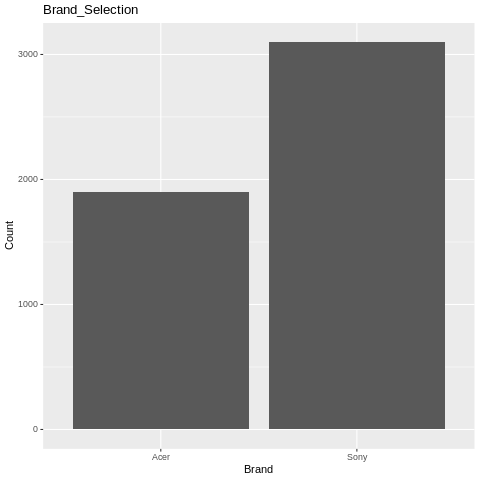

In [0]:
%%R
my.graph + ggtitle("Brand_Selection") + xlab("Brand") + ylab("Count")

**Changing color of bars**

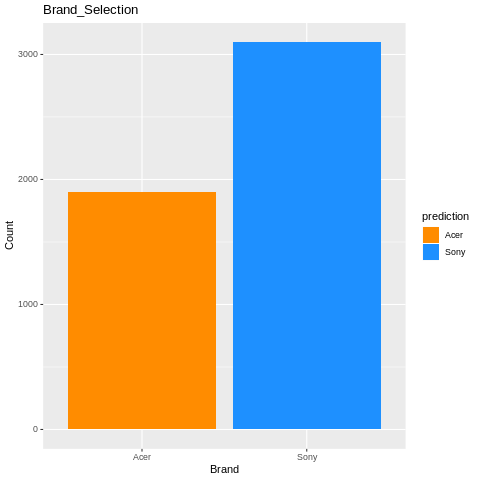

In [0]:
%%R
col.graph <- ggplot(SI, aes(x = prediction, fill = prediction  )) + 
             geom_bar() + ggtitle("Brand_Selection") + 
             scale_fill_manual(values = c("darkorange", "dodgerblue"))

col.graph + ggtitle("Brand_Selection") + xlab("Brand") + ylab("Count")

**Revesring name change**

In [0]:
%%R
SI$prediction = mapvalues(SI$prediction, from = c("Acer", "Sony"), to = c("0", "1"))

## Creating a graph for visualization of the existing data

In [0]:
%%R
ggplot(CompleteResponses, aes(x = brand)) + geom_bar()
my.graph <- ggplot(CompleteResponses, aes(x = brand)) + geom_bar()

**Changing name of observations from"0, 1" - to"Acer, Sony" and backward**

In [0]:
%%R
CompleteResponses$brand = mapvalues(CompleteResponses$brand, 
                          from = c("0", "1"), to = c("Acer", "Sony"))

**Changing name of graph & axis**

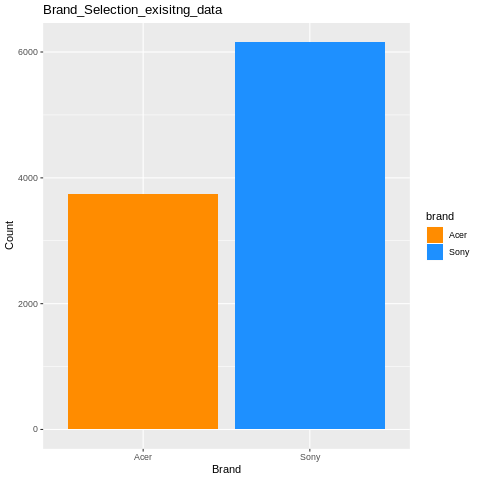

In [0]:
%%R
col.graph <- ggplot(CompleteResponses, aes(x = brand, fill = brand  )) + 
             geom_bar() + ggtitle("Brand_Selection_exisitng_data")  + 
             scale_fill_manual(values = c("darkorange", "dodgerblue"))

col.graph + ggtitle("Brand_Selection_exisitng_data") + xlab("Brand") + ylab("Count")

**Revesring name change**

In [0]:
%%R
CompleteResponses$brand = mapvalues(CompleteResponses$brand, 
                          from = c("Acer", "Sony"), to = c("0", "1"))

## Creating a histogram of salary & brand (with predictions in Incomplete Survey)

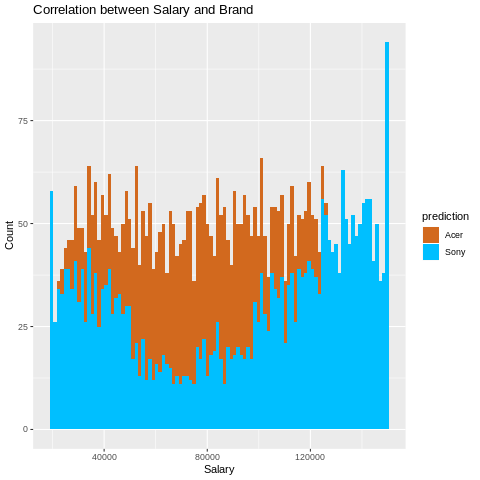

In [0]:
%%R
SI$prediction = mapvalues(SI$prediction, from = c("0", "1"), to = c("Acer", "Sony"))

hist.salary <- ggplot(SI, aes(x= salary, fill=prediction )) +
               geom_histogram(bins = 100 )

hist.salary + ggtitle("Correlation between Salary and Brand") + 
              xlab("Salary") + ylab("Count") + 
              scale_fill_manual(values = c("chocolate", "deepskyblue"))

## Creating a histogram of salary & brand (with Complete Survey)

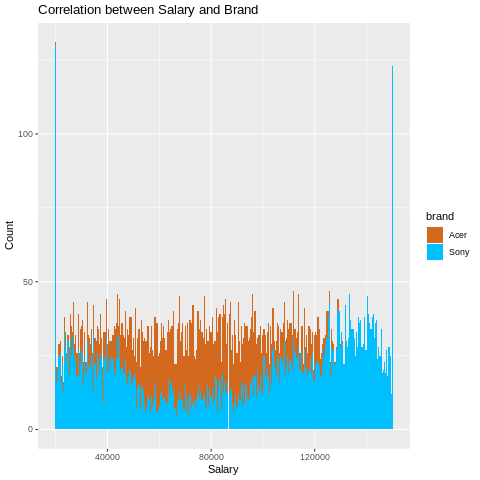

In [0]:
%%R
CompleteResponses$brand = mapvalues(CompleteResponses$brand, from = c("0", "1"), to = c("Acer", "Sony"))

hist.salary <- ggplot(CompleteResponses, aes(x= salary, fill=brand )) +
  geom_histogram(bins = 300 )

hist.salary + ggtitle("Correlation between Salary and Brand") + 
  xlab("Salary") + ylab("Count") + 
  scale_fill_manual(values = c("chocolate", "deepskyblue"))